In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
#Datei einlesen
df = pd.read_csv("heart3.csv")
#df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart3.csv")
df_orginal = df.copy()

In [46]:
#DataFrame-Beispiel Daten
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0


In [47]:
#DataFrame-Beispiel Daten
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0


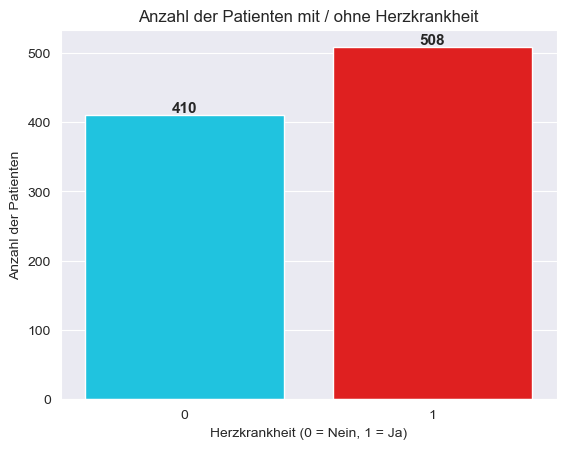

Anzahl der Zeilen (Patienten): 918
Anzahl der Spalten (Features): 12


In [48]:
#Balkendiagramm Anteil Herzerkrankte

# Balkendiagramm OHNE FutureWarning
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)


# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

# Zahlen über Balken schreiben
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Plot anzeigen
plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

In [49]:
# Daten Vorverarbeitung
# Duplikate checken
# Alle duplizierten Zeilen (inkl. Erstvorkommen)
duplikate_df = df[df.duplicated(keep=False)]

# Anzahl und Prozent Duplikate
anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease in den Duplikaten
verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100

# Verteilung HeartDisease im gesamten DataFrame
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 918
Anzahl mehrfach vorkommender Zeilen: 0
Prozent mehrfach vorkommend: 0.00%

Verteilung von Heartdisease innerhalb der Duplikate:
    - - -

Gesamtverteilung HeartDisease:
  1: 55.34%
  0: 44.66%


In [50]:
# Duplikate entfernen
df = df.drop_duplicates()


In [51]:
# Fehlende Werte prüfen
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [52]:
# Typprüfung
# also ob wirklich die im Datensatz angegebenen Datentypen und beizeichnungen stimen
def check_values(df, column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {(invalid)} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'M', 'F'},
    "ChestPainType": {'TA', 'ATA', 'NAP', 'ASY'},
    "RestingECG": {'Normal', 'ST', 'LVH'},
    "ExerciseAngina": {'Y', 'N'},
    "ST_Slope": {'Up', 'Flat', 'Down'}
}
def check_if_numeric (df, column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'FastingBS',
    'MaxHR',
    'Oldpeak',
    'HeartDisease'
]
# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(df, column, valid_set)

for col in numeric_columns:
    check_if_numeric(df, col, numeric_columns)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'ChestPainType' sind gültig 
Alle Werte in Spalte 'RestingECG' sind gültig 
Alle Werte in Spalte 'ExerciseAngina' sind gültig 
Alle Werte in Spalte 'ST_Slope' sind gültig 
Alle Werte in Spalte 'Age' sind numerisch.
Alle Werte in Spalte 'RestingBP' sind numerisch.
Alle Werte in Spalte 'Cholesterol' sind numerisch.
Alle Werte in Spalte 'FastingBS' sind numerisch.
Alle Werte in Spalte 'MaxHR' sind numerisch.
Alle Werte in Spalte 'Oldpeak' sind numerisch.
Alle Werte in Spalte 'HeartDisease' sind numerisch.


In [53]:
print(f"Anzahl an Zeilen: {len(df)}")
# Unrealistische Werte
# aufgrund von Medizinischen Hintergründen
def check_unrealistic_values(columnName, min_val, max_val):

    series = df[columnName]
    _df = df[(df[columnName] >= min_val) & (df[columnName] <= max_val)]

    invalid = series[(series < min_val) | (series > max_val)]
    print(f"{columnName}: {len(invalid)} Werte außerhalb des akzeptieren Bereichs '{min_val}-{max_val}'")
    #print(f"    Beispiele: {invalid.unique()[:5]}")
    return _df


df = check_unrealistic_values('Age', 0, 120)
df = check_unrealistic_values('RestingBP', 40, 150)
df = check_unrealistic_values('Cholesterol', 1, 800)
df = check_unrealistic_values('MaxHR', 60, 202)
df = check_unrealistic_values('Oldpeak', 0, 5)

print(f"Neue Anzahl an Zeilen: {len(df)}")

Anzahl an Zeilen: 918
Age: 0 Werte außerhalb des akzeptieren Bereichs '0-120'
RestingBP: 118 Werte außerhalb des akzeptieren Bereichs '40-150'
Cholesterol: 144 Werte außerhalb des akzeptieren Bereichs '1-800'
MaxHR: 0 Werte außerhalb des akzeptieren Bereichs '60-202'
Oldpeak: 2 Werte außerhalb des akzeptieren Bereichs '0-5'
Neue Anzahl an Zeilen: 654


In [54]:
# Formatierung / Behandlung der Unrealistischen Werte
#Oldpeak
#df = df[(df['Oldpeak'] >= 0) & (df['Oldpeak'] <= 5)]

#print(f"Neue Anzahl an Zeilen: {df.shape[0]}")

In [ ]:
#Bias/Korrelation

print("=== Altersverteilung ===")
print(df['Age'].describe())

plt.figure(figsize=(8,5))
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter [Jahre]')
plt.ylabel('Anzahl')
plt.show()

=== Altersverteilung ===
count    654.000000
mean      52.255352
std        9.444636
min       28.000000
25%       45.000000
50%       53.000000
75%       59.000000
max       77.000000
Name: Age, dtype: float64


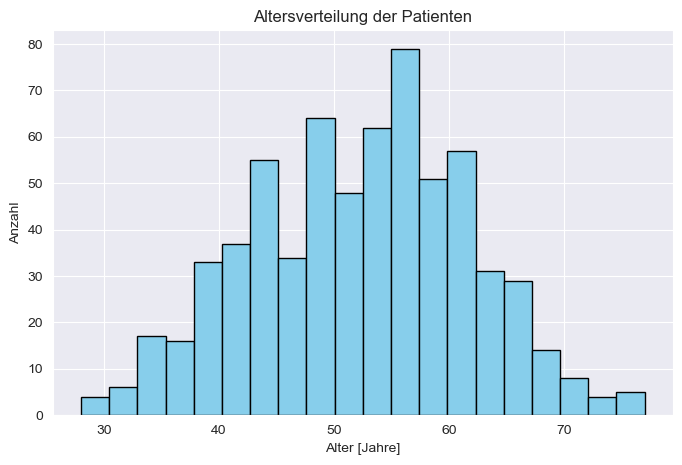

=== Geschlechterverteilung ===
M: 494 Patienten (75.54%)
F: 160 Patienten (24.46%)


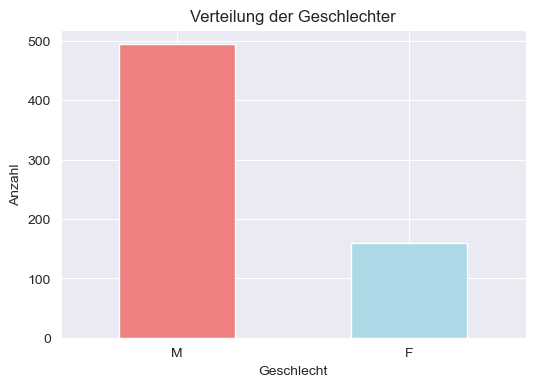

In [64]:
print("=== Geschlechterverteilung ===")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


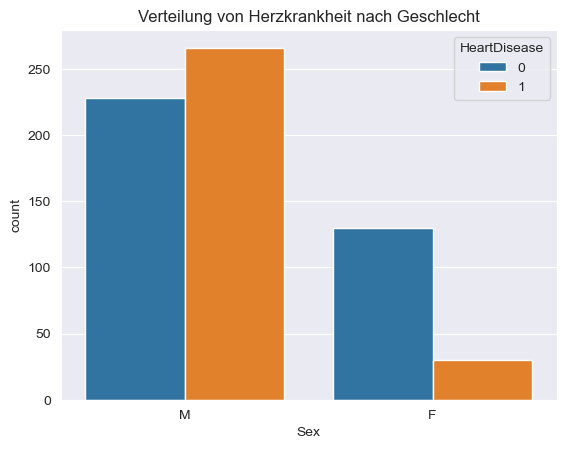

Sex
F    0.187500
M    0.538462
Name: HeartDisease, dtype: float64


In [56]:
# Bias: Zielverteilung nach Geschlecht
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

# Diagnosewahrscheinlichkeit pro Geschlecht
print(df.groupby("Sex")["HeartDisease"].mean())

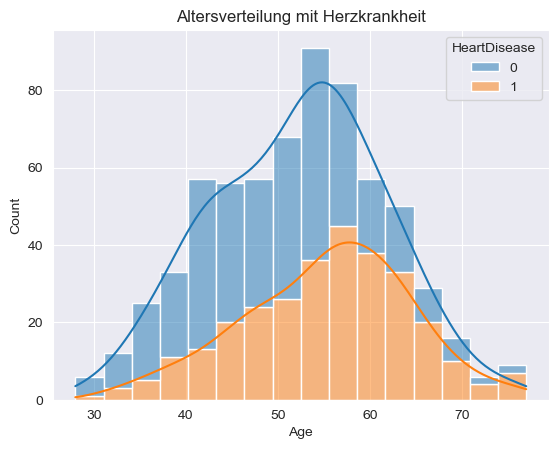

AgeGroup
20–40    0.263158
41–60    0.420000
61–80    0.679688
Name: HeartDisease, dtype: float64


In [57]:
#Bias: Altersverteilung mit/ohne Herzkrankheit
sns.histplot(data=df, x='Age', hue='HeartDisease', kde=True, multiple='stack')
plt.title("Altersverteilung mit Herzkrankheit")
plt.show()

# Altersgruppenbildung für Analyse
df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 40, 60, 80], labels=["20–40", "41–60", "61–80"])
print(df.groupby("AgeGroup", observed=True)["HeartDisease"].mean())


In [58]:
# Anteil Herzkrankheiten bei Fasting Blood Sugar hoch/niedrig
print(df.groupby("FastingBS")["HeartDisease"].mean())


FastingBS
0    0.422662
1    0.622449
Name: HeartDisease, dtype: float64


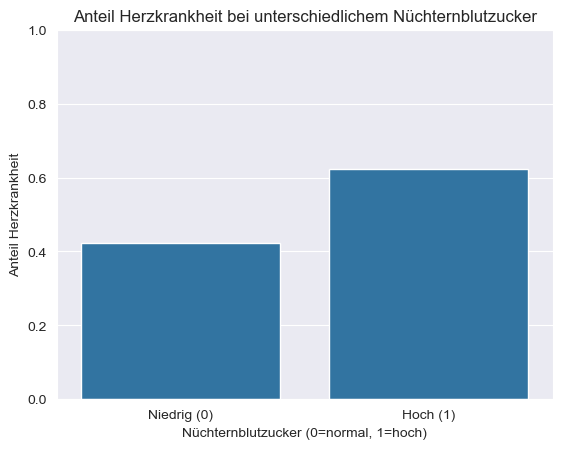

FastingBS
0    0.422662
1    0.622449
Name: HeartDisease, dtype: float64


In [59]:
# Anteil Herzkrankheiten pro Nüchternblutzucker
heart_disease_rate = df.groupby("FastingBS")["HeartDisease"].mean().reset_index()

# Plot mit Seaborn
sns.barplot(data=heart_disease_rate, x="FastingBS", y="HeartDisease")

plt.xticks([0, 1], ['Niedrig (0)', 'Hoch (1)'])
plt.ylabel("Anteil Herzkrankheit")
plt.xlabel("Nüchternblutzucker (0=normal, 1=hoch)")
plt.title("Anteil Herzkrankheit bei unterschiedlichem Nüchternblutzucker")
plt.ylim(0, 1)  # y-Achse von 0 bis 1
plt.show()

print(df.groupby("FastingBS")["HeartDisease"].mean())

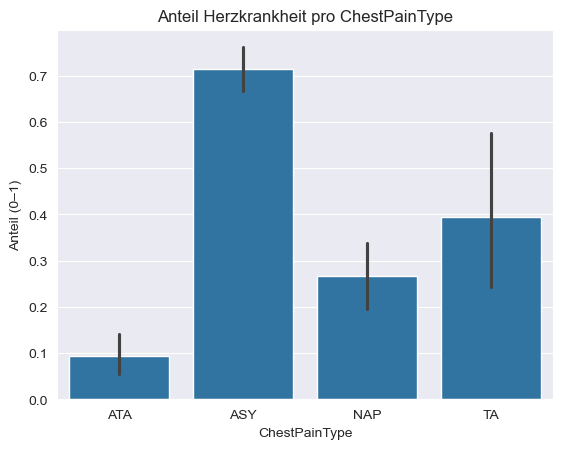

Anteil an Herzkrankheiten (%) pro ChestPainType:

ChestPainType
ASY    71.47
TA     39.39
NAP    26.62
ATA     9.46
Name: HeartDisease, dtype: float64


In [60]:
# Kreuztabelle: Anzahl Herzkrankheiten pro ChestPainType
#pd.crosstab(df['ChestPainType'], df['HeartDisease'], normalize='index') * 100

#  Anteil Herzkrankheit je ChestPainType
sns.barplot(
    data=df,
    x='ChestPainType',
    y='HeartDisease',
    estimator=lambda x: sum(x) / len(x)  # Mittelwert = Anteil Herzkrankheit
)
plt.title("Anteil Herzkrankheit pro ChestPainType")
plt.ylabel("Anteil (0–1)")
plt.show()

# Prozentsatz Herzkrankheit pro ChestPainType
heart_disease_by_cp = df.groupby("ChestPainType")["HeartDisease"].mean().sort_values(ascending=False) * 100

print("Anteil an Herzkrankheiten (%) pro ChestPainType:\n")
print(heart_disease_by_cp.round(2))

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Beispielhafte Feature-Liste (evtl. anpassen)
features = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
            'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

# Kategorische Features umwandeln
df_encoded = pd.get_dummies(df[features], drop_first=True)
X = df_encoded
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Gesamtergebnis:")
print(classification_report(y_test, y_pred))


Gesamtergebnis:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        90
           1       0.86      0.91      0.88        74

    accuracy                           0.89       164
   macro avg       0.89      0.89      0.89       164
weighted avg       0.89      0.89      0.89       164



In [62]:
# Feature Engineering
# Resting BP
def restingBP_categorization(bp):
    if bp < 120:
        return 'normal'
    elif 120<= bp <= 129:
        return 'elevated'
    elif 130<= bp <= 139:
        return 'hypertension1'
    elif 140<= bp <= 179:
        return 'hypertension2'
    else: return 'hypertension3'

df['RestingBP_cat'] = df['RestingBP'].apply(restingBP_categorization)

# Cholesterol
def cholesterol_categorization(cholesterol):
    if cholesterol < 200:
        return 'normal'
    elif 200<= cholesterol <= 239:
        return 'elevated'
    else: return 'high'

df['Cholesterol_cat'] = df['Cholesterol'].apply(cholesterol_categorization)

# Max HR
def maxhr_age_category(row):
    maxhr = row['MaxHR']
    age = row['Age']
    expected_maxhr = 220 - age

    if maxhr < 0.7 * expected_maxhr:
        return 'low'
    elif 0.7 * expected_maxhr <= maxhr <= expected_maxhr:
        return 'normal'
    elif expected_maxhr < maxhr <= 1.1 * expected_maxhr:
        return 'elevated'
    else:
        return 'high'

df['MaxHR_cat'] = df.apply(maxhr_age_category, axis=1)

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup,RestingBP_cat,Cholesterol_cat,MaxHR_cat
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0,20–40,hypertension2,high,normal
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0,20–40,hypertension1,high,low
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1,41–60,hypertension1,elevated,low
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0,41–60,hypertension2,normal,normal
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0,20–40,elevated,high,normal
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0,41–60,hypertension1,elevated,normal
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0,41–60,normal,elevated,normal
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1,20–40,hypertension2,elevated,normal
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0,41–60,elevated,high,low
10,37,F,NAP,130,211,0,Normal,142,N,0.000000,Up,0,20–40,hypertension1,elevated,normal
